# **Modelling Replication code**
This notebook replicates the main results presented in the paper, from training the model to analysing conservation scores.

In [1]:
from importlib import reload
import re
import random
random.seed(1337)
import os
import pickle
from decimal import Decimal
import collections

import numpy as np
np.random.seed(1337)
import pandas as pd
pd.options.mode.chained_assignment = None 
import scipy.stats as stats
from sklearn.linear_model import LinearRegression, Ridge

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import plotnine
import adjustText

# Dont use GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import tensorflow as tf
import keras
from keras import backend as K
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import model
import utils
import utils_data

Using TensorFlow backend.


In [2]:
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

#### Matplotlib config

In [2]:
import matplotlib_config

In [3]:
reload(matplotlib_config)
matplotlib_config.paper_config()

In [4]:
fig_dims = matplotlib_config.get_figsize(frac=1/3)

#### Utility functions

In [5]:
outputval_names = {"doudna": "rl_mean", "andreev":"log_load", "pcr3":"log_load", "eichhorn":"log_load",
                  "ptr":"ptr", "wilhelm":"ptr"}

# Function to compute correlations
def compute_corrs(df, model, one_hot_fn, key, extra_encoding_fn=[]):
    generator = utils_data.DataSequence(df, encoding_functions=[one_hot_fn] + extra_encoding_fn, 
                                                shuffle=False)
    predict = model.predict_generator(generator, verbose=0)
    return {"corr":(stats.pearsonr(predict.reshape(-1), df[outputval_names[key]]), 
                               stats.spearmanr(predict.reshape(-1), df[outputval_names[key]])),
            "pred":predict}

# Function to compute all test metrics
def compute_all_test_metrics(data_dict, model, min_len=None, extra_encoding_fn=[],
                             noTG = False,
                            postproc_mean=5.58621521, postproc_sd=1.34657403):
    result_dict = {}
    one_hot_fn = utils_data.OneHotEncoder("utr", min_len=min_len)
    # Test sets
    data_df = data_dict["mpra"]
    if noTG:
        data_df = data_df[~(data_df.utr.str[0:2] == "TG")]
    for key in ['egfp_unmod_1', 'mcherry_1', 'mcherry_2', 'egfp_unmod_2', 'human']:
        df = data_df[(data_df.library == key) & (data_df.set == "test")]
        generator = utils_data.DataSequence(df, encoding_functions=[one_hot_fn] + extra_encoding_fn, shuffle=False)
        predict = model.predict_generator(generator, verbose=0)
        if key == "egfp_unmod_1":
            result_dict[key] = (utils.rSquared(predict.reshape(-1), df["rl"]), utils.pearson_r(predict.reshape(-1), df["rl"])[0])
        else:
            result_dict[key] = utils.pearson_r(predict.reshape(-1), df["rl"])[0]
    varlen_df = data_dict["varlen_mpra"]
    for key in ['random', 'human']:
        df = varlen_df[(varlen_df.library == key) & (varlen_df.set == "test")]
        generator = utils_data.DataSequence(df, encoding_functions=[one_hot_fn] + extra_encoding_fn, shuffle=False)
        predict = model.predict_generator(generator, verbose=0)
        if key == "random":
            result_dict[key] = (utils.rSquared(predict.reshape(-1), df["rl"]), utils.pearson_r(predict.reshape(-1), df["rl"])[0])
        if key == "human":
            result_dict["human_varlen"] = utils.pearson_r(predict.reshape(-1), df["rl"])[0]
    # SNV
    df = data_dict["snv"]
    one_hot_fn_mother = utils_data.OneHotEncoder("mother", min_len=min_len)
    gen_wt = utils_data.DataSequence(df, encoding_functions=[one_hot_fn_mother] + extra_encoding_fn, shuffle=False)
    predict_wt = model.predict_generator(gen_wt, verbose=0)
    gen_snv = utils_data.DataSequence(df, encoding_functions=[one_hot_fn] + extra_encoding_fn, shuffle=False)
    predict_snv = model.predict_generator(gen_snv, verbose=0)
    if min_len is not None:
        predict_wt = predict_wt * postproc_sd + postproc_mean
        predict_snv = predict_snv * postproc_sd + postproc_mean
    log_pred_diff = np.log2(predict_snv/predict_wt)
    result_dict["snv"] = utils.pearson_r(log_pred_diff.reshape(-1), df["log_obs_diff"])[0]
    # Endogenous data
    for key in ["doudna", "andreev", "pcr3", "eichhorn", "ptr", "wilhelm"]:
        result_dict[key] = compute_corrs(data_dict[key], model, one_hot_fn, key, extra_encoding_fn=extra_encoding_fn)["corr"]
    return result_dict

# Function to compute metrics on endogenous data split by sequence length
def compute_split_metrics(data_dict, model, min_len=None, splits=[0, 100], extra_encoding_fn=[]):
    splits2 = splits[1:] + [1000000]
    result_dict = {str(split):{} for split in splits2[:-1]}
    result_dict["long"] = {}
    one_hot_fn = utils_data.OneHotEncoder("utr", min_len=min_len)
    for key in ["doudna", "andreev", "pcr3", "eichhorn", "ptr", "wilhelm"]:
        print("Analysing set: " + key)
        df = data_dict[key]
        for i in range(len(splits)):
            print("Analysing split from: " + str(splits[i]) + " to: " + str(splits2[i]))
            subset = df[(df.utr.str.len() > splits[i]) & (df.utr.str.len() <= splits2[i])]
            model_result = compute_corrs(subset, model, one_hot_fn, key, extra_encoding_fn=extra_encoding_fn)
            total_corr = model_result["corr"]
            pred = model_result["pred"]
            if i == len(splits) - 1:
                result_key = "long"
            else:
                result_key = str(splits2[i])
            result_dict[result_key][key] = {"corr":(total_corr[0][0], total_corr[1][0]),
                                           "pred":pred.reshape(-1),
                                           "obs":np.array(subset[outputval_names[key]]).reshape(-1)}
    return result_dict

# **Reading in the data**
Reading in the data pickle to run model training and/or evaluations

In [6]:
with open("../Data/data_dict.pkl", 'rb') as handle:
    data_dict = pickle.load(handle)

In [7]:
for key in data_dict:
    print(key)
    print(len(data_dict[key]))

mpra
980244
snv
1584
ptr
11575
wilhelm
5293
andreev
8003
pcr3
7672
eichhorn
8956
doudna
25831
varlen_mpra
102214


# **Training**
#### **(Skip if not making new model)**
This code shows how to train a framepool model from scratch

### Prepare training data

In [8]:
# length 50 mpra data
one_hot = utils_data.OneHotEncoder("utr")
mpra_data = data_dict["mpra"]
train_data_50 = mpra_data[(mpra_data.set == "train") & (mpra_data.library == "egfp_unmod_1")]
val_data = mpra_data[(mpra_data.set == "val") & (mpra_data.library == "egfp_unmod_1")]
encoded_mpra_train_50 = one_hot(train_data_50)
encoded_mpra_val = one_hot(val_data)

In [ ]:
# variable length (up to 100) mpra data
mpra_data_varlen = data_dict["varlen_mpra"]
train_data = mpra_data_varlen[(mpra_data_varlen.set == "train") & (mpra_data_varlen.library == "random")]
encoded_mpra_train = one_hot(train_data)

In [11]:
# combined length 50 and variable length mpra data
train_data_combined = pd.concat([train_data[["utr", "rl", "library"]], train_data_50[["utr", "rl", "library"]]])
one_hot_fn = utils_data.OneHotEncoder("utr")
library_fn = utils_data.LibraryEncoder("library", {"egfp_unmod_1":0, "random":1})
out_encoding_fn = utils_data.DataFrameExtractor("rl", method="direct")
generator_combined = utils_data.DataSequence(train_data_combined, encoding_functions=[one_hot_fn, library_fn], 
                                    output_encoding_fn=out_encoding_fn, shuffle=True)

In [613]:
# without TG start
train_data_noTG = train_data_combined[~(train_data_combined.utr.str[0:2] == "TG")]
generator_noTG = utils_data.DataSequence(train_data_noTG, encoding_functions=[one_hot_fn, library_fn], 
                                    output_encoding_fn=out_encoding_fn, shuffle=True)

### Train a Model

In [620]:
reload(model)
utr_model = model.create_frame_slice_model(kernel_size=[7,7,7],
                        only_max_pool=False,
                        padding="same",
                        skip_connections="residual",
                        use_scaling_regression=True, library_size=2)

In [621]:
utr_model.fit_generator(generator_noTG, epochs=6, verbose=2)

Epoch 1/6
 - 159s - loss: 1.2391
Epoch 2/6
 - 284s - loss: 0.6966
Epoch 3/6
 - 282s - loss: 0.5559
Epoch 4/6
 - 282s - loss: 0.4806
Epoch 5/6
 - 283s - loss: 0.4513
Epoch 6/6
 - 284s - loss: 0.4200


In [628]:
utr_model.save("../Models/utr_model_combined_residual_noTG.h5")

### Evaluate it

In [46]:
utr_model_combined = load_model("..Models/Framepool_combined_residual_noTG.h5", custom_objects={'FrameSliceLayer': model.FrameSliceLayer})

In [623]:
metrics = compute_all_test_metrics(data_dict, utr_model, extra_encoding_fn=[library_fn], noTG = True)

In [625]:
# pickle and save
with open("../Data/Metrics/metrics_frameslice_combined_noTG_dict.pkl", 'wb') as handle:
    pickle.dump(metrics, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [626]:
with open("../Data/Metrics/metrics_frameslice_50_dict.pkl", 'rb') as handle:
    metrics_frameslice_50 = pickle.load(handle)
with open("../Data/Metrics/metrics_frameslice_100_dict.pkl", 'rb') as handle:
    metrics_frameslice_100 = pickle.load(handle)
with open("../Data/Metrics/metrics_frameslice_combined_dict.pkl", 'rb') as handle:
    metrics_frameslice_combined = pickle.load(handle)
with open("../Data/Metrics/metrics_frameslice_combined_noTG_dict.pkl", 'rb') as handle:
    metrics_frameslice_combined_noTG = pickle.load(handle)

In [627]:
for key in metrics_frameslice_100:
    print(key)
    print(metrics_frameslice_50[key])
    print(metrics_frameslice_100[key])
    print(metrics_frameslice_combined[key])
    print(metrics_frameslice_combined_noTG[key])

egfp_unmod_1
(0.9221064552942099, 0.9286913985005334)
(0.6238430947475788, 0.8626600121588603)
(0.9021292130831058, 0.9097982804043929)
(0.9176483663963254, 0.9234777685505821)
mcherry_1
0.6937217350567138
0.6557430404941327
0.6901184146770003
0.6983342416428424
mcherry_2
0.7625899974346826
0.7168778661688588
0.7495499047058781
0.7667770474909021
egfp_unmod_2
0.8502690102010035
0.8066638829680413
0.8314158699899794
0.8469290748854641
human
0.7779039427378039
0.7043140526130449
0.7515240412710117
0.7791964628818739
random
(-0.02819618345471775, 0.8109036397203787)
(0.79706930893472, 0.814719212159738)
(0.8315714881284952, 0.8348638498491876)
(0.7982508671235763, 0.8111453721672645)
human_varlen
0.7594276408239143
0.7807088113039873
0.79846334514603
0.7606855349993633
snv
0.5317956093905337
0.5247975465973355
0.5369803198493659
0.5136090571166904
doudna
((0.12579558122090928, 1.350383713736952e-91), SpearmanrResult(correlation=0.13118200770847457, pvalue=1.65365573710095e-99))
((0.156308

# **Validations**


## **Import all models**
We import all the models we need to run the validations

In [9]:
# Load models
utr_model_50 = load_model("../Models/utr_model_50.h5", custom_objects={'FrameSliceLayer': model.FrameSliceLayer}) # Framepool50
utr_model = load_model("../Models/utr_model_100_residual.h5", custom_objects={'FrameSliceLayer': model.FrameSliceLayer}) # Framepool100
library_fn = utils_data.LibraryEncoder("library", {"egfp_unmod_1":0, "random":1})
utr_model_combined = load_model("../Models/utr_model_combined_residual.h5", custom_objects={'FrameSliceLayer': model.FrameSliceLayer}) # FramepoolCombined
utr_model_combined_noTG = load_model("../Models/utr_model_combined_residual_noTG.h5", custom_objects={'FrameSliceLayer': model.FrameSliceLayer})
paper_model_orig = load_model("../Models/main_MRL_model.hdf5") # Optimus50
paper_model = load_model("../Models/retrained_main_MRL_model.hdf5") 
paper_model2 = load_model("../Models/Varying_length_25to100_model.hdf5") # Optimus100
modelname_dict = {"Optimus50": paper_model_orig, "Framepool50": utr_model_50,
                  "Optimus100": paper_model2, "Framepool100": utr_model, "FramepoolCombined": utr_model_combined}

## **Validation on MPRA data**
We plot the performance of our models and Optimus models on MPRA data

In [10]:
# Code to run a prediction on MPRA data
def predict_on_MPRA(model, data_dict, varlen = False, library = "egfp_unmod_1", min_len = None,
                    extra_encoding_fn=[], postproc_mean=5.58621521, postproc_sd=1.34657403):
    one_hot_fn = utils_data.OneHotEncoder("utr", min_len=min_len)
    if varlen:
        data_df = data_dict["varlen_mpra"].copy()
    else:
        data_df = data_dict["mpra"].copy()
    df = data_df[(data_df.library == library) & (data_df.set == "test")]
    generator = utils_data.DataSequence(df, encoding_functions=[one_hot_fn] + extra_encoding_fn, shuffle=False)
    predict = model.predict_generator(generator, verbose=0)
    if min_len is not None:
        predict = predict * postproc_sd + postproc_mean
    df["pred"] = predict.reshape(-1)
    df = df.rename(columns={"pred": "Predicted MRL", "rl": "Observed MRL"})
    return df

In [11]:
# build dataframe
def build_mpra_prediction():
    concat_df = pd.DataFrame(columns=['Predicted MRL', 'Observed MRL', 'model', 'data', 'R'])
    for modelname in ["Optimus50", "Framepool50", "Optimus100", "Framepool100", "FramepoolCombined"]:
        predmodel = modelname_dict[modelname]
        min_len = None
        if modelname == "Optimus50":
            min_len = 50
        if modelname == "Optimus100":
            min_len = 100
        extra_encoding_function = []
        if modelname == "FramepoolCombined":
            extra_encoding_function = [library_fn] 
        for data in [("Fixed length (50 nt) MPRA", "egfp_unmod_1", False), ("Variable length (25-100 nt) MPRA", "random", True)]:
            varlen = data[2]
            dataname = data[0]
            library = data[1]
            pred_df = predict_on_MPRA(predmodel, data_dict, varlen = varlen, library = library, min_len = min_len,
                                     extra_encoding_fn = extra_encoding_function)
            pred_df = pred_df[["Predicted MRL", "Observed MRL"]]
            #print((modelname, dataname))
            pred_df["model"] = modelname
            pred_df["data"] = dataname
            pred_df["R"] = round(stats.pearsonr(pred_df["Predicted MRL"], pred_df["Observed MRL"])[0], 3)
            concat_df = pd.concat([concat_df, pred_df])
    return concat_df

mpra_pred_df = build_mpra_prediction()

In [12]:
mpra_pred_df[["model", "data", "R"]].drop_duplicates()

,model,data,R
0,Optimus50,Fixed length (50 nt) MPRA,0.966
1,Optimus50,Variable length (25-100 nt) MPRA,0.743
0,Framepool50,Fixed length (50 nt) MPRA,0.964
1,Framepool50,Variable length (25-100 nt) MPRA,0.901
0,Optimus100,Fixed length (50 nt) MPRA,0.938
1,Optimus100,Variable length (25-100 nt) MPRA,0.915
0,Framepool100,Fixed length (50 nt) MPRA,0.929
1,Framepool100,Variable length (25-100 nt) MPRA,0.903
0,FramepoolCombined,Fixed length (50 nt) MPRA,0.954
1,FramepoolCombined,Variable length (25-100 nt) MPRA,0.914


/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


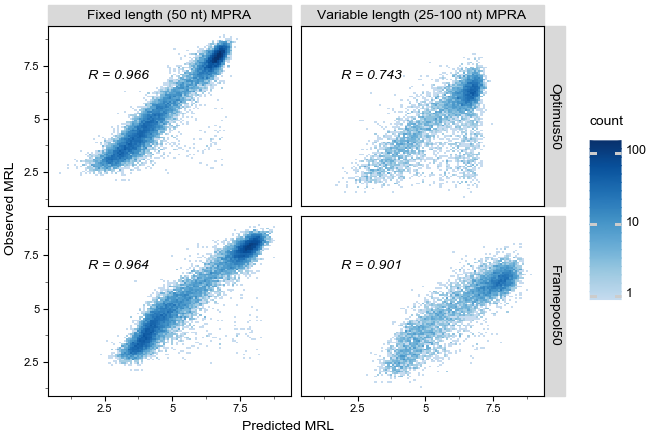

<ggplot: (-9223363284445303692)>

In [583]:
# Build a subset
mpra_pred_df_sub = mpra_pred_df[mpra_pred_df.model.isin(["Optimus50","Framepool50"])]

# Fix labels
plotlabel_dict = {"A": "Optimus50", "B": "Framepool50", "C": "Fixed length (50 nt) MPRA", "D": "Variable length (25-100 nt) MPRA"}
inv_plotlabel_dict = {v: k for k, v in plotlabel_dict.items()}
mpra_pred_df_sub["model_factor"] = mpra_pred_df_sub["model"].apply(lambda x: inv_plotlabel_dict[x])
mpra_pred_df_sub["data_factor"] = mpra_pred_df_sub["data"].apply(lambda x: inv_plotlabel_dict[x])
mpra_pred_R_df_sub = mpra_pred_df_sub[["model_factor", "data_factor", "R"]].drop_duplicates()
mpra_pred_R_df_sub["R"] = mpra_pred_R_df_sub["R"].apply(lambda x: "R = " + str(x))
labeller = plotnine.facets.labelling.as_labeller(plotlabel_dict)

# Plot
p = (plotnine.ggplot(mpra_pred_df_sub, plotnine.aes('Predicted MRL', 'Observed MRL'))
 #+ plotnine.geom_point(alpha = 0.05, shape = ".", color = "darkblue")
 + plotnine.geom_bin2d(binwidth = 0.08)
 + plotnine.scale_fill_continuous(ListedColormap(cm.get_cmap('Blues', 512)(np.linspace(0.25, 1, 384))), trans="log10")
 #+ plotnine.labs(fill="")
 + plotnine.facet_grid('model_factor ~ data_factor', labeller = labeller)
 + plotnine.geom_text(size = 10, data = mpra_pred_R_df_sub, mapping = plotnine.aes(x = 3, y = 7, label = "R"), fontstyle = "italic")
 + plotnine.theme_matplotlib())
p

In [584]:
p.save("../Graphics/" + "Fig2" + ".svg", width=7.0, height=7.0*0.66)

/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 7.0 x 4.62 in image.
  from_inches(height, units), units), PlotnineWarning)
/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../Graphics/Fig2.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)
/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1

## **Validation on endogenous data**
We plot the performance of our models and Optimus models on endogenous data, split by sequence length

#### Compute split metrics

In [ ]:
metrics_split_optimus_50 = compute_split_metrics(data_dict, paper_model, min_len=50, splits=[0, 50])
metrics_split_frameslice_50 = compute_split_metrics(data_dict, utr_model_50, splits=[0, 50])

In [ ]:
metrics_split_optimus_100 = compute_split_metrics(data_dict, paper_model2, min_len=100)
metrics_split_frameslice_100 = compute_split_metrics(data_dict, utr_model)

In [ ]:
metrics_split_frameslice_combined = compute_split_metrics(
    data_dict, utr_model_combined, extra_encoding_fn=[library_fn])

In [60]:
# Save computed metrics
with open("../Data/Metrics/metrics_split_optimus_50_dict.pkl", 'wb') as handle:
    pickle.dump(metrics_split_optimus_50, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open("../Data/Metrics/metrics_split_frameslice_50_dict.pkl", 'wb') as handle:
    pickle.dump(metrics_split_frameslice_50, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open("../Data/Metrics/metrics_split_optimus_100_dict.pkl", 'wb') as handle:
    pickle.dump(metrics_split_optimus_100, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open("../Data/Metrics/metrics_split_frameslice_100_dict.pkl", 'wb') as handle:
    pickle.dump(metrics_split_frameslice_100, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open("../Data/Metrics/metrics_split_frameslice_combined_dict.pkl", 'wb') as handle:
    pickle.dump(metrics_split_frameslice_combined, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### Prepare dataframe for plotting

In [14]:
# Load metrics
with open("../Data/Metrics/metrics_split_frameslice_50_dict.pkl", 'rb') as handle:
    metrics_split_frameslice_50 = pickle.load(handle)
with open("../Data/Metrics/metrics_split_optimus_50_dict.pkl", 'rb') as handle:
    metrics_split_optimus_50 = pickle.load(handle)
with open("../Data/Metrics/metrics_split_frameslice_100_dict.pkl", 'rb') as handle:
    metrics_split_frameslice_100 = pickle.load(handle)
with open("../Data/Metrics/metrics_split_optimus_100_dict.pkl", 'rb') as handle:
    metrics_split_optimus_100 = pickle.load(handle)
with open("../Data/Metrics/metrics_split_frameslice_combined_dict.pkl", 'rb') as handle:
    metrics_split_frameslice_combined = pickle.load(handle)

In [17]:
# build dataframe with data types, correlations and bootstrapping significance results
# Facet grid categories:
splittype_1 = "Human 5'UTR shorter than longest training sequence"
splittype_2 = "Human 5'UTR longer than longest training sequence"
traintype_1 = "Trained on 50 nt MPRA"
traintype_2 = "Trained on 25-100 nt MPRA"

In [851]:
# build dataframe with data types, correlations and bootstrapping significance results
metricname_dict = {"Optimus50": metrics_split_optimus_50, "Framepool50": metrics_split_frameslice_50,
                  "Optimus100": metrics_split_optimus_100, "Framepool100": metrics_split_frameslice_100}

def corr_wrapper(pred, obs, corr = "pearson"):
    if corr == "pearson":
        return stats.pearsonr(pred, obs)[0]
    else:
        return stats.spearmanr(pred, obs)[0]

# bootstrapping
def do_bootstrap(df, n_samples=100, std_factor=stats.norm.ppf(0.9998), corr = "pearson"):
    our_bootstrap = []
    paper_bootstrap = []
    for i in range(n_samples):
        sub = df.sample(frac=1, replace=True)
        our_bootstrap.append(corr_wrapper(sub["pred_our"], sub["obs_our"], corr = corr))
        paper_bootstrap.append(corr_wrapper(sub["pred_paper"], sub["obs_paper"], corr = corr))
    diff = [x - y for x,y in zip(our_bootstrap, paper_bootstrap)]
    mean_diff = np.mean(diff)
    error_diff = np.std(diff)*std_factor
    sig = "Significant"
    if mean_diff < 0 and mean_diff + error_diff > 0:
        sig = "Not " + sig
    elif mean_diff > 0 and mean_diff - error_diff < 0:
        sig = "Not " + sig
    return sig

def build_mpra_prediction():
    datalabels_dict = {"doudna":"Floor", "andreev":"Andreev", "pcr3":"Xiao", "eichhorn":"Eichhorn", "ptr":"Eraslan", "wilhelm":"Wilhelm"}
    datatype_dict = {"doudna":"Trip-seq", "andreev":"Ribo-seq", "pcr3":"Ribo-seq", "eichhorn":"Ribo-seq", "ptr":"PTR", "wilhelm":"PTR"}
    splittype_dict = {"50": splittype1, 
                      "100": splittype1,
                     "long": splittype2}
    traindatatype_dict = {"50": traintype_1, 
                          "100": traintype_2}
    rows_list = []
    for comparison in [("Optimus50", "Framepool50", "50"), ("Optimus100", "Framepool100", "100")]:
        for split in [comparison[2], "long"]:
            for data in ["doudna", "andreev", "pcr3", "eichhorn", "ptr", "wilhelm"]:
                bootstrap_df = pd.DataFrame({"pred_paper": metricname_dict[comparison[0]][split][data]["pred"],
                        "obs_paper":metricname_dict[comparison[0]][split][data]["obs"],
                        "pred_our":metricname_dict[comparison[1]][split][data]["pred"],
                        "obs_our":metricname_dict[comparison[1]][split][data]["obs"]})
                r_optimus = stats.pearsonr(bootstrap_df["pred_paper"], bootstrap_df["obs_paper"])[0]
                r_framepool = stats.pearsonr(bootstrap_df["pred_our"], bootstrap_df["obs_our"])[0]
                rho_optimus = stats.spearmanr(bootstrap_df["pred_paper"], bootstrap_df["obs_paper"])[0]
                rho_framepool = stats.spearmanr(bootstrap_df["pred_our"], bootstrap_df["obs_our"])[0]
                sig = do_bootstrap(bootstrap_df, corr = "pearson")
                sig_rho = do_bootstrap(bootstrap_df, corr = "spearman")
                row = {"Pearson's R of Optimus predictions with observed values": r_optimus,
                      "Pearson's R of Framepool predictions with observed values": r_framepool,
                       "Spearman's rho of Optimus predictions with observed values": rho_optimus,
                      "Spearman's rho of Framepool predictions with observed values": rho_framepool,
                       "significant_diff_Pearson": sig,
                       "significant_diff_Spearman": sig_rho,
                      "data": datalabels_dict[data],
                      "data_type": datatype_dict[data],
                      "split_type": splittype_dict[split],
                      "train_data_type": traindatatype_dict[comparison[2]]}
                rows_list.append(row)
    return pd.DataFrame(rows_list)

split_metric_df = build_mpra_prediction()

In [867]:
# save
split_metric_df.to_csv("../Data/Metrics/split_metric_df.csv")

#### Plot split metrics

In [15]:
split_metric_df = pd.read_csv("../Data/Metrics/split_metric_df.csv")

/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/plotnine/scales/scale_alpha.py:70: PlotnineWarning: Using alpha for a discrete variable is not advised.
  PlotnineWarning
/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)
/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 1 rows con

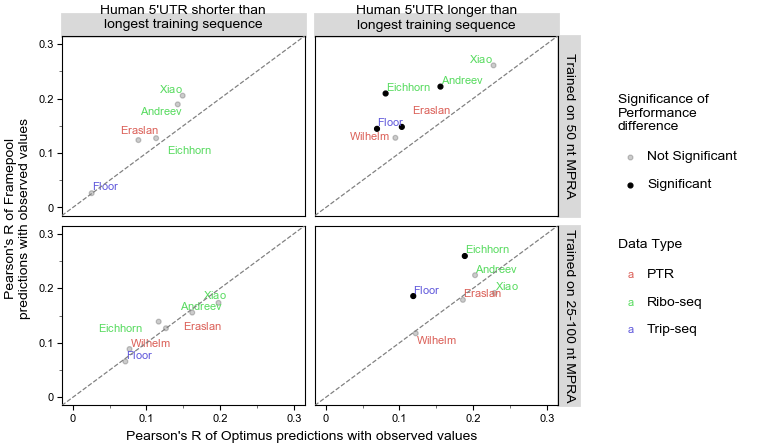

<ggplot: (8752693881608)>

In [597]:
# Make categoricals for values used to order facet grid
split_metric_df['split_type_cat'] = pd.Categorical(split_metric_df['split_type'], categories=[splittype_1,splittype_2])
split_metric_df['train_type_cat'] = pd.Categorical(split_metric_df['train_data_type'], categories=[traintype_1,traintype_2])

# Labels
x_lab = "Pearson's R of Optimus predictions with observed values"
y_lab = "Pearson's R of Framepool\npredictions with observed values"
plotlabel_dict = {traintype_1: "Trained on 50 nt MPRA", traintype_2: "Trained on 25-100 nt MPRA", 
                  splittype_1: "Human 5'UTR shorter than\nlongest training sequence\n", 
                  splittype_2: "Human 5'UTR longer than\nlongest training sequence\n"}
labeller = plotnine.facets.labelling.as_labeller(plotlabel_dict) # facet labeller

# Adjust text parameters
adjust_text_dict = {
    'x': split_metric_df["Pearson's R of Optimus predictions with observed values"],
    'y': split_metric_df["Pearson's R of Framepool predictions with observed values"],
    "expand_text": (2,2),
    "avoid_point": True,
    "avoid_text": True,
    #'expand_points': (2, 2)
    #'arrowprops': {
    #    'arrowstyle': '->',
    #    'color': 'red'
    #}
}

# Plot
p = (plotnine.ggplot(split_metric_df, plotnine.aes("Pearson's R of Optimus predictions with observed values", 
                                                    "Pearson's R of Framepool predictions with observed values"))
 + plotnine.geom_point(plotnine.aes(alpha="significant_diff_Pearson"))
 + plotnine.scale_alpha_discrete(range = [0.2, 1.0])
 + plotnine.scales.scale_shape_manual(values=["o", "^", "v"])
 + plotnine.geom_text(plotnine.aes(label="data", color="data_type"), parse=True, size=8, adjust_text=adjust_text_dict)
 + plotnine.xlab(x_lab)
 + plotnine.ylab(y_lab) 
 + plotnine.xlim(0, 0.3) 
 + plotnine.ylim(0, 0.3)
 + plotnine.labs(alpha="Significance of\nPerformance\ndifference", shape="Data Type", color="Data Type")
 + plotnine.facet_grid('train_type_cat ~ split_type_cat', labeller=labeller)
 + plotnine.geom_abline(color="grey", linetype="--")
 + plotnine.theme_matplotlib()
 + plotnine.theme(strip_background=plotnine.element_rect(size=2)))
p

In [599]:
p.save("../Graphics/" + "Fig3" + ".svg")

/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../Graphics/Fig3.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)
/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.

## **TIS Strength validation**
We prepare and run our in-silico experiment to evaluate our model's understanding of uTIS motifs

#### Load data

In [43]:
noderer_df_aug = pd.read_csv("../Data/TIS/tis_efficiencies_aug.tsv", sep='\t')
noderer_df_aug = noderer_df_aug.rename(index=str, columns={"sequence":"TIS_Sequence", "efficiency":"TIS_Efficiency"})
noderer_df_nonaug = pd.read_csv("../Data/TIS/tis_efficiencies_nonaug.tsv", sep='\t')

# Recode U to T
noderer_df_aug["TIS_Sequence"] = noderer_df_aug["TIS_Sequence"].str.replace("U", "T")
noderer_df_nonaug["TIS_Sequence"] = noderer_df_nonaug["TIS_Sequence"].str.replace("U", "T")

#### Compute predicted impact of AUG TIS motifs

In [ ]:
# Prepare injection
noderer_df_aug["TIS_Sequence_AGG"] = [seq[:7] + "G" + seq[8:] for seq in noderer_df_aug["TIS_Sequence"]]
bad_end = noderer_df_aug["TIS_Sequence"].str.endswith("AT")
double_trouble = noderer_df_aug["TIS_Sequence_AGG"].str.contains("ATG")
noderer_df_aug_sub = noderer_df_aug[(~bad_end) & (~double_trouble)]
noderer_df_aug = noderer_df_aug_sub

In [55]:
# run prediction
extra_encoding_fn = [library_fn]
model_to_apply = utr_model_combined

one_hot_fn_inactive = utils_data.OneHotEncoder("wt")
one_hot_fn_active = utils_data.OneHotEncoder("snv")
samples = 100
diffs = []
for i in range(samples):
    prefix = ''.join(random.choices(["C","T","G"], k=9)) # fast way to get AUG free seq 
    suffix = ''.join(random.choices(["C","T","G"], k=9)) # fast way to get AUG free seq
    noderer_df_aug["snv"] = [prefix + seq + suffix for seq in
                                            noderer_df_aug["TIS_Sequence"]]
    noderer_df_aug["wt"] = [prefix + seq + suffix for seq in
                                        noderer_df_aug["TIS_Sequence_AGG"]]
    gen_wt = utils_data.DataSequence(noderer_df_aug, encoding_functions=[one_hot_fn_inactive] + extra_encoding_fn, 
                                     shuffle=False)
    predict_wt_only = model_to_apply.predict_generator(gen_wt, verbose=0)
    gen_snv = utils_data.DataSequence(noderer_df_aug, encoding_functions=[one_hot_fn_active] + extra_encoding_fn, 
                                      shuffle=False)
    predict_snv_only = model_to_apply.predict_generator(gen_snv, verbose=0)
    log_pred_diff_only = np.log2(predict_snv_only/predict_wt_only)
    diffs.append(log_pred_diff_only)
diffs = sum(diffs)/len(diffs)
noderer_df_aug["Predicted log2 Fold Change"] = diffs.reshape(-1)
print(stats.pearsonr(noderer_df_aug["TIS_Efficiency"], diffs.reshape(-1)))
print(stats.spearmanr(noderer_df_aug["TIS_Efficiency"], diffs.reshape(-1)))

(-0.7946999837983739, 0.0)
SpearmanrResult(correlation=-0.7648457052769003, pvalue=0.0)


In [260]:
# save results
with open("../Data/tis_aug_diffs.pkl", 'wb') as handle:
    pickle.dump(diffs, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### Compute predicted impact of non-AUG TIS motifs

In [115]:
# Remove AUG creating motifs
atg_trouble = noderer_df_nonaug["TIS_Sequence"].str.contains("ATG")
noderer_df_nonaug = noderer_df_nonaug[~atg_trouble]

In [ ]:
# Prepara dataframe
extra_encoding_fn = [library_fn]
model_to_apply = utr_model_combined

nonaug_dict = {key:noderer_df_nonaug[noderer_df_nonaug["TIS_Sequence"].str[-4:-1] == key] for key in
               set(noderer_df_nonaug["TIS_Sequence"].str[-4:-1])}

In [ ]:
# make random seq without AUG
def random_seq_noaug(exclude_motifs=["CTG","GTG"]):
    seq = ''.join(random.choices(["A","C","T","G"], k=9))
    # (try to) clean out unwanted motifs that could eat results
    for motif in exclude_motifs:
        motifs_present = [m.start() for m in re.finditer(motif, seq)]
        for idx in motifs_present:
            seq = seq[:idx] + ''.join(random.choices(["A","C","T","G"], k=2)) + seq[idx+3:]
    # (surely) clean out atg, since they dominate everything
    atg_present = [m.start() for m in re.finditer('ATG', seq)]
    for idx in atg_present:
        seq = seq[:idx] + "C" + ''.join(random.choices(["C","T","G"], k=2)) + seq[idx+3:]
    return seq
    
# Predict
key_to_inactive = {'CTG':"CTT", 'ACG':"ACT", 'AAG':"AAC", 'GTG':"GTT", 
                   'ATA':"ACT", 'AGG':"AGT", 'ATT':"GTT", 'ATC':"GTC", 
                   'TTG':"TTT"}
one_hot_fn_inactive = utils_data.OneHotEncoder("wt")
one_hot_fn_active = utils_data.OneHotEncoder("snv")
samples = 100
for key in nonaug_dict.keys():
    nonaug_dict[key]["TIS_inactive"] = [seq[:-4] + key_to_inactive[key] + seq[-1] for seq in
                                        nonaug_dict[key]["TIS_Sequence"]]
    diff_list = []
    for i in range(samples):
        prefix = random_seq_noaug()
        suffix = random_seq_noaug()
        nonaug_dict[key]["snv"] = [prefix + seq + suffix for seq in
                                            nonaug_dict[key]["TIS_Sequence"]]
        nonaug_dict[key]["wt"] = [prefix + seq + suffix for seq in
                                        nonaug_dict[key]["TIS_inactive"]]
        gen_wt = utils_data.DataSequence(nonaug_dict[key], encoding_functions=[one_hot_fn_inactive] + extra_encoding_fn, 
                                         shuffle=False)
        predict_wt_nonaug = model_to_apply.predict_generator(gen_wt, verbose=0)
        gen_snv = utils_data.DataSequence(nonaug_dict[key], encoding_functions=[one_hot_fn_active] + extra_encoding_fn, 
                                          shuffle=False)
        predict_snv_nonaug = model_to_apply.predict_generator(gen_snv, verbose=0)
        log_pred_diff_nonaug = np.log2(predict_snv_nonaug/predict_wt_nonaug)
        diff_list.append(log_pred_diff_nonaug)
    print("iteration done")
    diffs = sum(diff_list)/len(diff_list)    
    nonaug_dict[key]["Predicted log2 Fold Change"] = diffs

In [493]:
metrics_nonaug = {}
for key in nonaug_dict.keys():
    metrics_nonaug[key] = (stats.pearsonr(nonaug_dict[key]["TIS_Efficiency"], nonaug_dict[key]["Predicted log2 Fold Change"]),
                              stats.spearmanr(nonaug_dict[key]["TIS_Efficiency"], nonaug_dict[key]["Predicted log2 Fold Change"]))
metrics_nonaug

{'AAG': ((-0.03440265768038109, 0.27902976029671517),
  SpearmanrResult(correlation=-0.030494363555976896, pvalue=0.33732523911247003)),
 'ATT': ((-0.12590394548409262, 6.999356650786765e-05),
  SpearmanrResult(correlation=-0.16920250717035082, pvalue=8.267592782968615e-08)),
 'TTG': ((-0.1623542108665238, 2.729712475105104e-07),
  SpearmanrResult(correlation=-0.2729657331829091, pvalue=2.0728406009558696e-18)),
 'ACG': ((-0.4796661805834739, 3.253064290016916e-58),
  SpearmanrResult(correlation=-0.4214353656336449, pvalue=5.512931892074104e-44)),
 'ATA': ((0.039739283161079234, 0.21110029674594122),
  SpearmanrResult(correlation=-0.009030268918752284, pvalue=0.7763606996471601)),
 'ATC': ((-0.04868401162803133, 0.1254413781741276),
  SpearmanrResult(correlation=-0.03625437431698441, pvalue=0.25395138271483436)),
 'GTG': ((-0.39164618718940497, 2.1941395761878936e-35),
  SpearmanrResult(correlation=-0.3095590967285146, pvalue=4.655452853987824e-22)),
 'CTG': ((-0.7128739788659265, 9.78

In [494]:
# Save
with open("../Data/nonaug_dict.pkl", 'wb') as handle:
    pickle.dump(nonaug_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### Load all datasets, combine and plot in combined plot

In [576]:
# AUG
with open("../Data/tis_aug_diffs.pkl", 'rb') as handle:
    diffs = pickle.load(handle)
noderer_df_aug["Predicted log2 Fold Change"] = diffs.reshape(-1)
noderer_df_aug["PredFC"] = (2 ** noderer_df_aug["Predicted log2 Fold Change"])*100 - 100
noderer_df_aug["codon"] = "AUG"
noderer_df_aug_reduced = noderer_df_aug[['TIS_Sequence', 'TIS_Efficiency', "PredFC", "codon"]]

# Non aug
with open("../Data/nonaug_dict.pkl", 'rb') as handle:
    nonaug_dict = pickle.load(handle)
df_list = []
for key in nonaug_dict.keys():
    if key not in ["CTG", "GTG"]:
        continue
    nonaug_dict[key]["codon"] = key.replace("T","U")
    nonaug_dict[key]["PredFC"] = (2 ** nonaug_dict[key]["Predicted log2 Fold Change"])*100 - 100
    df_list.append(nonaug_dict[key][['TIS_Sequence', 'TIS_Efficiency', "PredFC", "codon"]])
combined_nonaug = pd.concat(df_list)

# combine
combined_codon_df = pd.concat([noderer_df_aug_reduced, combined_nonaug])
# copy
all_df = combined_codon_df.copy()
allname = "Combined"
all_df["codon"] = allname
# combine with copy
combined_all = pd.concat([all_df, combined_codon_df[combined_codon_df.codon.isin(["AUG", "CUG", "GUG"])]])


# compute correlations
codon_keys = [allname, "AUG", "CUG", "GUG"]
r_list = []
for key in codon_keys:
    subcodon_df = combined_all[combined_all.codon == key]
    r = "R = " + str(round(stats.pearsonr(subcodon_df["TIS_Efficiency"], subcodon_df["PredFC"])[0], 3))
    r_list.append(r)
r_dat = pd.DataFrame({"codon":codon_keys,"r":r_list})

In [578]:
r_dat

,codon,r,codon_cat,x_pos,y_pos
0,Combined,R = -0.852,Combined,-10,125
1,AUG,R = -0.802,AUG,-10,125
2,CUG,R = -0.712,CUG,-1,40
3,GUG,R = -0.394,GUG,-1,19


/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed

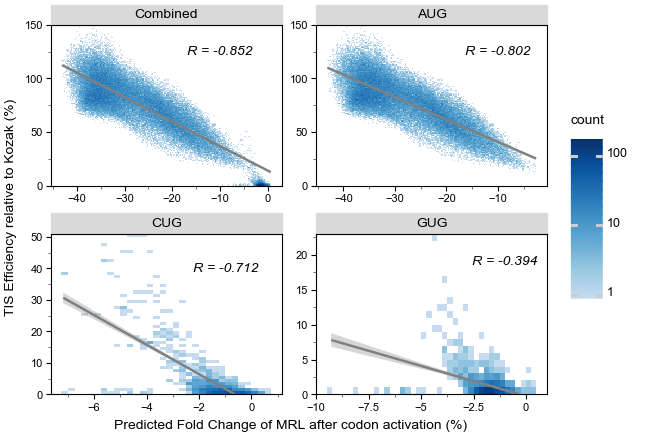

<ggplot: (8752453244641)>

In [581]:
combined_all['codon_cat'] = pd.Categorical(combined_all['codon'], categories=codon_keys)
r_dat['codon_cat'] = pd.Categorical(r_dat['codon'], categories=codon_keys)
r_dat["x_pos"] = [-10, -10, -1, -1]
r_dat["y_pos"] = [125, 125, 40, 19]

# Plot
p = (plotnine.ggplot(combined_all, plotnine.aes('PredFC', 'TIS_Efficiency'))
 #+ plotnine.geom_point(alpha = 0.05, shape = ".", color = "darkblue")
 + plotnine.geom_bin2d(binwidth = [0.25,1])
 + plotnine.scale_y_continuous(limits = (0, float("NaN")), expand=(0,0))
 + plotnine.scale_fill_continuous(ListedColormap(cm.get_cmap('Blues', 512)(np.linspace(0.25, 1, 384))), trans="log10")
 #+ plotnine.labs(fill="")
 + plotnine.xlab("Predicted Fold Change of MRL after codon activation (%)")
 + plotnine.ylab("TIS Efficiency relative to Kozak (%)")
 #+ plotnine.scale_x_continuous(trans='log10')
 #+ plotnine.annotation_logticks(sides="b")
 + plotnine.stat_smooth(method='lm', color="grey")
 + plotnine.facet_wrap("codon_cat", scales="free")
 + plotnine.geom_text(size = 10, data = r_dat, mapping = plotnine.aes(x = "x_pos", y = "y_pos", label = "r"), fontstyle = "italic")
 + plotnine.theme_matplotlib()
 + plotnine.theme(subplots_adjust={'wspace':0.15, "hspace":0.3}))
 #+ plotnine.theme(legend_direction="horizontal", legend_position = (0.75, 0.80)))
p

In [579]:
p.save("../Graphics/" + "Fig5_combined" + ".svg")

/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../Graphics/Fig5_combined.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)
/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/data/ouga0

#### Load results for AUG and plot

In [41]:
with open("../Data/tis_aug_diffs.pkl", 'rb') as handle:
    diffs = pickle.load(handle)
    
noderer_df_aug["Predicted log2 Fold Change"] = diffs.reshape(-1)

/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


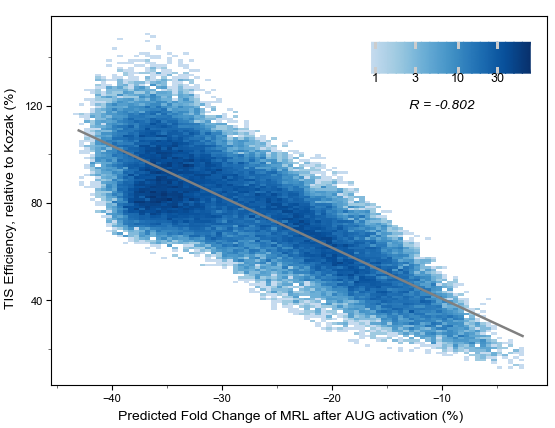

<ggplot: (8752666629601)>

In [113]:
noderer_df_aug["PredFC"] = (2 ** noderer_df_aug["Predicted log2 Fold Change"])*100 - 100

r = ["R = " + str(round(stats.pearsonr(noderer_df_aug["TIS_Efficiency"], noderer_df_aug["PredFC"])[0], 3))]
r_dat = pd.DataFrame({"r":r})

# Plot
p = (plotnine.ggplot(noderer_df_aug, plotnine.aes('PredFC', 'TIS_Efficiency'))
 #+ plotnine.geom_point(alpha = 0.05, shape = ".", color = "darkblue")
 + plotnine.geom_bin2d(binwidth = [0.5,1])
 + plotnine.scale_fill_continuous(ListedColormap(cm.get_cmap('Blues', 512)(np.linspace(0.25, 1, 384))), trans="log10")
 + plotnine.labs(fill="")
 + plotnine.xlab("Predicted Fold Change of MRL after AUG activation (%)")
 + plotnine.ylab("TIS Efficiency, relative to Kozak (%)")
 #+ plotnine.scale_x_continuous(trans='log10')
 #+ plotnine.annotation_logticks(sides="b")
 + plotnine.stat_smooth(method='lm', color="grey")
 + plotnine.geom_text(size = 10, data = r_dat, x = -10, y = 120, label = r, fontstyle = "italic")
 + plotnine.theme_matplotlib()
 + plotnine.theme(legend_direction="horizontal", legend_position = (0.75, 0.80)))
p

In [114]:
p.save("../Graphics/" + "Fig5_AUG" + ".svg", width=4, height=3.0)

/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 4 x 3.0 in image.
  from_inches(height, units), units), PlotnineWarning)
/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../Graphics/Fig5_AUG.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)
/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'dat

#### Load results for non-AUG and plot

In [489]:
with open("../Data/nonaug_dict.pkl", 'rb') as handle:
    nonaug_dict = pickle.load(handle)

In [152]:
for key in nonaug_dict.keys():
    subnonaug_df = nonaug_dict[key]
    subnonaug_df["PredFC"] = (2 ** subnonaug_df["Predicted log2 Fold Change"])*100 - 100

In [168]:
# merge dataframes for CUG and GUG
cug_df = nonaug_dict["CTG"]
cug_df["codon"] = "CUG"
gug_df = nonaug_dict["GTG"]
gug_df["codon"] = "GUG"
nonaugplot_df = pd.concat([cug_df, gug_df])
r_cug = "R = " + str(round(stats.pearsonr(cug_df["TIS_Efficiency"],cug_df["PredFC"])[0], 3))
r_gug = "R = " + str(round(stats.pearsonr(gug_df["TIS_Efficiency"],gug_df["PredFC"])[0], 3))
r_nonaugdf = pd.DataFrame({"codon":["CUG", "GUG"],"r":[r_cug, r_gug]})

/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)
/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/plotnine/laye

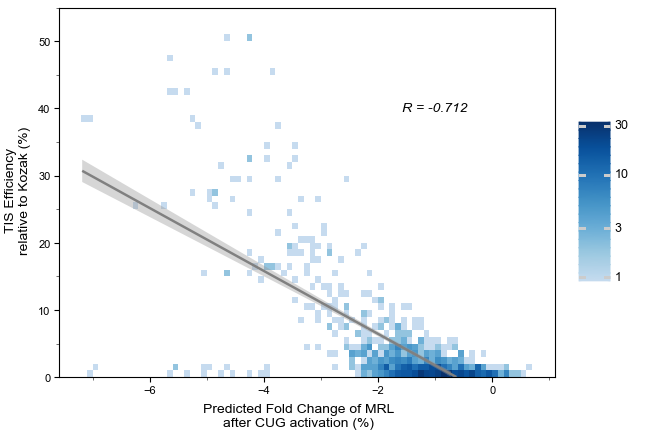

<ggplot: (-9223363284185521194)>

In [296]:
# Plot for CUG
subnonaug_df = nonaug_dict["CTG"]

r = ["R = " + str(round(stats.pearsonr(subnonaug_df["TIS_Efficiency"],subnonaug_df["PredFC"])[0], 3))]
r_dat = pd.DataFrame({"r":r})

# Plot
p = (plotnine.ggplot(subnonaug_df, plotnine.aes('PredFC', 'TIS_Efficiency'))
 #+ plotnine.geom_point(alpha = 0.05, shape = ".", color = "darkblue")
 + plotnine.geom_bin2d(binwidth = [0.1,1])
 + plotnine.scale_y_continuous(expand = (0,0), limits = (0,55))
 + plotnine.scale_fill_continuous(ListedColormap(cm.get_cmap('Blues', 512)(np.linspace(0.25, 1, 384))), trans="log10")
 + plotnine.labs(fill="")
 + plotnine.xlab("Predicted Fold Change of MRL\nafter CUG activation (%)")
 + plotnine.ylab("TIS Efficiency\nrelative to Kozak (%)")
 #+ plotnine.scale_x_continuous(trans='log10')
 #+ plotnine.annotation_logticks(sides="b")
 + plotnine.stat_smooth(method='lm', color="grey")
 + plotnine.geom_text(size = 10, data = r_dat, x = -1, y = 40, label = r, fontstyle = "italic")
 + plotnine.theme_matplotlib())
 #+ plotnine.theme(legend_direction="horizontal", legend_position = (0.75, 0.80)))
p

In [297]:
p.save("../Graphics/" + "Fig5_CUG" + ".svg", width=2.5, height=2.0)

/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 2.5 x 2.0 in image.
  from_inches(height, units), units), PlotnineWarning)
/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../Graphics/Fig5_CUG.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)
/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'd

/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)
/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/plotnine/laye

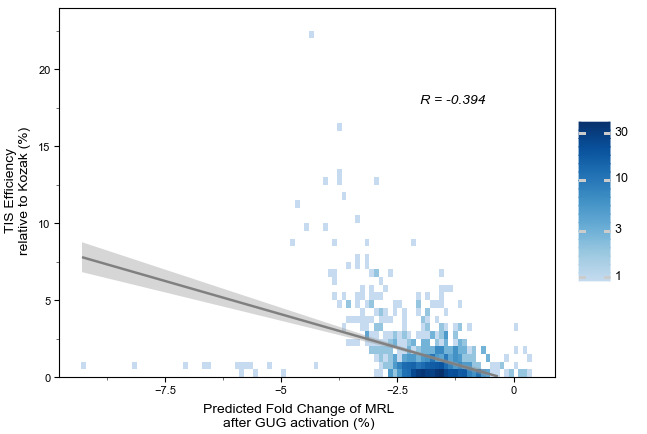

<ggplot: (-9223363284182047642)>

In [299]:
# Plot for GUG
subnonaug_df = nonaug_dict["GTG"]

r = ["R = " + str(round(stats.pearsonr(subnonaug_df["TIS_Efficiency"],subnonaug_df["PredFC"])[0], 3))]
r_dat = pd.DataFrame({"r":r})

# Plot
p = (plotnine.ggplot(subnonaug_df, plotnine.aes('PredFC', 'TIS_Efficiency'))
 #+ plotnine.geom_point(alpha = 0.05, shape = ".", color = "darkblue")
 + plotnine.geom_bin2d(binwidth = [0.1,0.5])
 + plotnine.scale_y_continuous(expand = (0,0), limits = (0,24))
 + plotnine.scale_fill_continuous(ListedColormap(cm.get_cmap('Blues', 512)(np.linspace(0.25, 1, 384))), trans="log10")
 + plotnine.labs(fill="")
 + plotnine.xlab("Predicted Fold Change of MRL\nafter GUG activation (%)")
 + plotnine.ylab("TIS Efficiency\nrelative to Kozak (%)")
 #+ plotnine.scale_x_continuous(trans='log10')
 #+ plotnine.annotation_logticks(sides="b")
 + plotnine.stat_smooth(method='lm', color="grey")
 + plotnine.geom_text(size = 10, data = r_dat, x = -1.3, y = 18, label = r, fontstyle = "italic")
 + plotnine.theme_matplotlib())
 #+ plotnine.theme(legend_direction="horizontal", legend_position = (0.75, 0.80)))
p

In [300]:
p.save("../Graphics/" + "Fig5_GUG" + ".svg", width=2.5, height=2.0)

/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 2.5 x 2.0 in image.
  from_inches(height, units), units), PlotnineWarning)
/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../Graphics/Fig5_GUG.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)
/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'd

## **Nonaug Sequences (Behaviour on 50nt set w/o AUG)**

An analysis to check how the model behaves on non-aug sequences

#### Structure

In [595]:
one_hot_fn = utils_data.OneHotEncoder("utr")
library_fn = utils_data.LibraryEncoder("library", {"egfp_unmod_1":0, "random":1})
data_noaug = mpra_data[(mpra_data.library == "egfp_unmod_1") & (mpra_data.set != "test")
                          & (~mpra_data.utr.str.contains("ATG"))]
generator_noaug = utils_data.DataSequence(data_noaug, encoding_functions=[one_hot_fn, library_fn], 
                                    output_encoding_fn=None, shuffle=False)
data_noaug["pred"] = utr_model_combined.predict_generator(generator_noaug).reshape(-1)
data_noaug_noTG = data_noaug[~(data_noaug["utr"].str[0:2] == "TG")]

In [607]:
print(stats.pearsonr(data_noaug["pred"], data_noaug["rl"]))

(0.6244264796490494, 0.0)


In [598]:
print(stats.pearsonr(data_noaug["pred"], -data_noaug["utr_energy"]))
print(stats.spearmanr(data_noaug["pred"], -data_noaug["utr_energy"]))

(-0.34569959913646864, 0.0)
SpearmanrResult(correlation=-0.38942085700797147, pvalue=0.0)


#### GC Content

In [599]:
print(stats.pearsonr(data_noaug["pred"], (data_noaug["utr"].str.count("G") + data_noaug["utr"].str.count("C"))/50))
print(stats.spearmanr(data_noaug["pred"], (data_noaug["utr"].str.count("G") + data_noaug["utr"].str.count("C"))/50))

(-0.5236313655690584, 0.0)
SpearmanrResult(correlation=-0.6182908032577178, pvalue=0.0)


#### Kozak sequence

In [605]:
data_noaug["kozak"] = data_noaug["utr"].str[-6:]
one_hot_kozak = utils_data.OneHotEncoder("kozak")
X = one_hot_kozak(data_noaug).reshape((len(data_noaug), 24))
y = np.array(data_noaug["pred"])
reg = LinearRegression().fit(X, y)
r2 = reg.score(X, y)
print("LinReg r2 : " + str(reg.score(X, y)))
reg = Ridge().fit(X, y)
print("Ridge r2 : " + str(reg.score(X, y)))

LinReg r2 : 0.15968792595404746
Ridge r2 : 0.15973801648879915


In [601]:
r2_adjusted = utils.adjust_r2(r2, X.shape[0], X.shape[1])
print(r2_adjusted)

0.22862655766465856


In [587]:
for idx in range(6):
    print("Pos: " + str(idx - 6))
    print("A: " + str(reg.coef_[0 + idx*4]))
    print("C: " + str(reg.coef_[1 + idx*4]))
    print("G: " + str(reg.coef_[2 + idx*4]))
    print("T: " + str(reg.coef_[3 + idx*4]))

Pos: -6
A: 0.04121955237332102
C: -0.07356027494544327
G: 0.007399498568564108
T: 0.024941224000093968
Pos: -5
A: 0.007604155571840407
C: -0.03273682637528169
G: -0.0394832739687865
T: 0.06461594476707097
Pos: -4
A: 0.05937809131318027
C: -0.013196113103436246
G: -0.04178055925970393
T: -0.004401418942868569
Pos: -3
A: 0.11810353734944945
C: -0.0608052462583951
G: 0.09861034609381161
T: -0.15590863718131645
Pos: -2
A: 0.04616225626456959
C: 0.009201051385165143
G: -0.10685821405827228
T: 0.051494906408202784
Pos: -1
A: 0.05648181806729322
C: -0.005107575439702407
G: -0.03994896116630581
T: -0.011425281447469184


In [606]:
print(data_noaug[data_noaug["kozak"].str[-3] == "A"]["pred"].mean())
print(data_noaug[data_noaug["kozak"].str[-3] == "C"]["pred"].mean())
print(data_noaug[data_noaug["kozak"].str[-3] == "G"]["pred"].mean())
print(data_noaug[data_noaug["kozak"].str[-3] == "T"]["pred"].mean())

7.635938
7.4565187
7.60665
7.36476


In [568]:
r2_by_pos = []
for idx in range(1,12):
    print(-idx)
    data_noaug["kozak_pos"] = data_noaug["utr"].str[-idx]
    one_hot_pos = utils_data.OneHotEncoder("kozak_pos")
    X = one_hot_pos(data_noaug).reshape(len(data_noaug), 4)
    y = np.array(data_noaug["pred"])
    reg = Ridge().fit(X, y)
    print(reg.score(X, y))
    r2_by_pos.append(reg.score(X, y))

-1
0.012188875804470145
-2
0.02414924758904602
-3
0.08449375707108842
-4
0.016089828631844938
-5
0.01028407362951278
-6
0.01299960331535499
-7
0.0069745245756122065
-8
0.008652044125863956
-9
0.006335419061400227
-10
0.007645239697720352
-11
0.008511548426793691


In [570]:
np.sum(r2_by_pos[:6])

0.1602053860413173

## **Conservation: PhyloP score validation**
We predict the effect of all possible snv in loss of of function genes and compare it to the phyloP conservation scores

In [183]:
from kipoiseq.extractors import FastaStringExtractor
from kipoiseq.extractors import MultiSampleVCF, VariantSeqExtractor
from kipoiseq.dataloaders.sequence import BedDataset
from kipoiseq.utils import to_scalar

import pybedtools
from pybedtools import BedTool, Interval

#### Some useful functions

In [425]:
# Function to create an in-silico SNP array
nuc_dict = {'a':[1.0,0.0,0.0,0.0],'c':[0.0,1.0,0.0,0.0],'g':[0.0,0.0,1.0,0.0], 'u':[0.0,0.0,0.0,1.0], 
            't':[0.0,0.0,0.0,1.0], 'n':[0.0,0.0,0.0,0.0], 'x':[1/4,1/4,1/4,1/4]}
permutation_array = np.array([[1.0,0.0,0.0,0.0], [0.0,1.0,0.0,0.0], [0.0,0.0,1.0,0.0], [0.0,0.0,0.0,1.0]])

def create_permutations(seq, min_len=None):
    n = len(seq) * 4
    seq = seq.lower()
    one_hot = np.array([nuc_dict[x] for x in seq])
    one_hot_permuted = np.repeat(one_hot[np.newaxis,:,:], n, axis=0)
    for i in range(len(seq)):
        one_hot_permuted[i*4:(i*4)+4,i] = permutation_array
    if min_len is not None:
        diff = min_len - len(seq)
        if diff > 0:
            padding = np.zeros((n+1,diff, 4))
            one_hot_permuted = np.concatenate([one_hot[np.newaxis,:,:], one_hot_permuted], axis=0)
            one_hot_permuted = np.concatenate([padding, one_hot_permuted], axis=1)
        if diff < 0:
            one_hot_permuted = one_hot_permuted[np.abs(diff)*4:,np.abs(diff):,:]
            one_hot_permuted = np.concatenate([one_hot[np.newaxis,np.abs(diff):,:], one_hot_permuted], axis=0)
        if diff == 0:
            one_hot_permuted = np.concatenate([one_hot[np.newaxis,:,:], one_hot_permuted], axis=0)
    else:
        one_hot_permuted = np.concatenate([one_hot[np.newaxis,:,:], one_hot_permuted], axis=0)
    return one_hot_permuted

def create_snv_array(seq, model, min_len=None,
                     postproc_mean=5.269942112451139, postproc_sd=1.3551744190850261,
                    add_frame=False, add_library=False, suppress_postproc=False):
    if add_frame:
        frame = utils.build_frame(len(seq), (len(seq)*4) + 1)
        predictions = model.predict([create_permutations(seq, min_len=min_len), frame])
    elif add_library:
        indicator = np.zeros(((len(seq)*4) + 1,2))
        indicator[:,1] = 1
        predictions = model.predict([create_permutations(seq, min_len=min_len), indicator])
    else:
        predictions = model.predict(create_permutations(seq, min_len=min_len))
    if min_len is not None and not suppress_postproc:
        predictions =  predictions * postproc_sd + postproc_mean
    delta = np.log2(predictions[1:]/predictions[0])
    if min_len is not None and len(seq) > min_len:
        delta = delta.reshape((min_len, 4))
        diff = len(seq) - min_len
        padding = np.zeros((diff, 4))
        delta = np.concatenate([padding, delta], axis=0)
    else:
        delta = delta.reshape((len(seq), 4))
    return delta

def write_arrays(df, model, path, min_len=None, add_frame=False, add_library=False,
                 suppress_postproc=False,
                check_and_skip=False):
    for seq_id, seq in zip(df["EnsemblTranscriptID"], df["utr"]):
        if len(seq) == 1:
            continue
        if check_and_skip and os.path.exists(path + "SNPdelta_" + seq_id + ".npy"):
            continue
        delta = create_snv_array(seq, model, min_len=min_len, add_frame=add_frame, add_library=add_library,
                                suppress_postproc=suppress_postproc)
        np.save(path + "SNPdelta_" + seq_id + ".npy", np.transpose(delta))

def read_array(pos_df, transcript_id, base_path = "../Data/All_Variants/",
              snv_path="Genecode_v19_new/", cons_path="phylop/"):
    array = np.load(base_path + snv_path + "SNPdelta_" + transcript_id + ".npy")
    pos = pos_df[pos_df.EnsemblTranscriptID == transcript_id].iloc[0]
    indices = np.concatenate([np.arange(x[0],x[1]) for x in eval(pos["pos"])])
    atg_dist = np.flip(np.arange(len(indices))) + 1
    conservation = np.load(base_path + cons_path + "phyloP_" + transcript_id + ".npy")
    if pos["strand"] == "-":
        indices = np.flip(indices)
        conservation = np.flip(conservation)
    return pd.DataFrame({"EnsemblTranscriptID":pos["EnsemblTranscriptID"], 
                         "chr":pos["chr"], "strand":pos["strand"], "pos_ensembl":indices+1,
                         "dist_to_atg":atg_dist,
                         "conservation":conservation,
                        "A":array[0,:],"C":array[1,:],"G":array[2,:],"T":array[3,:]})

def read_all_arrays(pos_df, snv_path="Genecode_v19_frameslice_100/"):
    data = []
    i = 0
    for transcript_id in pos_df["EnsemblTranscriptID"]:
        arr = read_array(pos_df, transcript_id, snv_path=snv_path)
        data.append(arr)
        if i % 1000 == 0:
            print(i)
        i += 1
    arr = pd.concat(data)
    return arr

#### Load needed data

In [185]:
seq_df = pd.read_csv("../Data/gencodev19_5utr_seq.csv")
pos_df = pd.read_csv("../Data/gencodev19_5utr_pos.csv")
# remove length 1 utrs, as they can not yield sensible predictions and only mess with numpy
seq_df = seq_df[seq_df["utr"].str.len() > 1]
pos_df = pos_df[pos_df["EnsemblTranscriptID"].
                isin(seq_df[seq_df["utr"].str.len() > 1]["EnsemblTranscriptID"])]
# reduce to lof intolerant genes
# Lof intolerant: "oe_lof_upper" < 0.35
lof_df = pd.read_csv("../Data/GTF/gencodev19_5utr_lof.bed", sep="\t",
                     names=["chr", "start", "stop", "EnsemblTranscriptID", "?", "strand"])
pos_df = pos_df[pos_df["EnsemblTranscriptID"].isin(lof_df["EnsemblTranscriptID"])]
seq_df = seq_df[seq_df["EnsemblTranscriptID"].isin(lof_df["EnsemblTranscriptID"])]

#### Compute and Write all snv effects for all 5'UTR of lof transcripts

In [127]:
write_arrays(seq_df, utr_model, "../Data/All_Variants/Genecode_v19_frameslice_100/")

In [91]:
write_arrays(seq_df, utr_model_combined, "../Data/All_Variants/Genecode_v19_frameslice_combined/", add_library=True)

In [161]:
# write for utr model with truncation
write_arrays(seq_df, utr_model, "../Data/All_Variants/Genecode_v19_frameslice_100_truncated/", min_len=100, suppress_postproc=True)

In [316]:
seq_df_100 = seq_df["EnsemblTranscriptID"][seq_df["utr"].str.len() <= 100]
seq_df_long = seq_df["EnsemblTranscriptID"][seq_df["utr"].str.len() > 100]

In [389]:
# write arrays for paper model
write_arrays(seq_df[seq_df["EnsemblTranscriptID"].isin(seq_df_100)], paper_model2, 
                    "../Data/All_Variants/Genecode_v19_paper/", min_len=100)

/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in log2


In [426]:
# write arrays for paper model with truncation
write_arrays(seq_df, paper_model2, 
                    "../Data/All_Variants/Genecode_v19_paper_truncated_rescale/", min_len=100)

#### Load results

In [186]:
# results for our model (framepool100), untruncated sequences
arr = read_all_arrays(pos_df)

0
1000
2000
3000
4000
5000
6000
7000
8000


In [187]:
# results for our model on truncated sequences
arr_truncated = read_all_arrays(pos_df, snv_path="Genecode_v19_frameslice_100_truncated/")

0
1000
2000
3000
4000
5000
6000
7000
8000


In [427]:
# results for the optimus100 model on truncated sequences
arr_paper_truncated = read_all_arrays(pos_df, snv_path="Genecode_v19_paper_truncated_rescale/")

0
1000
2000
3000
4000
5000
6000
7000
8000


In [466]:
# concatenate dataframes
arr_far = arr[arr["dist_to_atg"] > 100]
arr_far["model"] = "Framepool100"
arr_far["data"] = ">100nt from canonical AUG"
arr_truncated = arr_truncated[arr_truncated["dist_to_atg"] <= 100]
arr_truncated["model"] = "Framepool100"
arr_truncated["data"] = "within 100nt of canonical AUG"
arr_paper_truncated = arr_paper_truncated[arr_paper_truncated["dist_to_atg"] <= 100]
arr_paper_truncated["model"] = "Optimus100"
arr_paper_truncated["data"] = "within 100nt of canonical AUG"
snveffect_df = pd.concat([arr_far, arr_truncated, arr_paper_truncated])
# compute the average absolute fold change
snveffect_df["avg_effect"] = np.sum(np.abs(np.array(snveffect_df[["A","C","G","T"]])), axis = 1)/3

In [469]:
# average for identical position over different transcripts
id_col = list(zip(snveffect_df["model"], snveffect_df["data"],
                        snveffect_df["chr"], snveffect_df["pos_ensembl"]))
snveffect_df["id_col"] = id_col
snveffect_posaggreg = snveffect_df.groupby("id_col").agg({'avg_effect': 'mean', "conservation": "max"})
snveffect_posaggreg["model"] = [x[0] for x in snveffect_posaggreg.index]
snveffect_posaggreg["data"] = [x[1] for x in snveffect_posaggreg.index]
snveffect_posaggreg["chr"] = [x[2] for x in snveffect_posaggreg.index]
snveffect_posaggreg["pos_ensembl"] = [x[3] for x in snveffect_posaggreg.index]
snveffect_posaggreg = snveffect_posaggreg.reset_index()[["avg_effect", "conservation", 
                                                         "model", "data", "chr", "pos_ensembl"]]
snveffect_posaggreg["avg_effect_FC"] =  ((2 ** snveffect_posaggreg["avg_effect"]) * 100) - 100

In [358]:
# compute averages
avg_within100nt = snveffect_posaggreg[snveffect_posaggreg.data == "within 100nt of canonical AUG"]["conservation"].mean()
avg_far = snveffect_posaggreg[snveffect_posaggreg.data == ">100nt from canonical AUG"]["conservation"].mean()
df_avgphylop = pd.DataFrame({"data": ["within 100nt of canonical AUG", ">100nt from canonical AUG"], 
                             "average conservation": [avg_within100nt, avg_far]})

In [328]:
avg_within100nt

1.5570408849089066

In [470]:
cuts = [0, 10, 25, 50, 100]
bin_labels = ["<10", "10-25", "25-50", "50-100", ">100"]

# bin the data
def bin_data(cuts, labels, score_col="avg_effect_FC"):
    df_list = []
    for model in ["Optimus100", "Framepool100"]:
        for data in ["within 100nt of canonical AUG", ">100nt from canonical AUG"]:
            df = snveffect_posaggreg[(snveffect_posaggreg.model == model) & (snveffect_posaggreg.data == data)]
            if len(df) == 0:
                continue
            cuts2 = cuts[1:] + [100000]
            binned_phylop = []
            binned_error = []
            binned_counts = []
            for i in range(len(labels)):
                l = cuts[i]
                u = cuts2[i]
                sub_df = df[(df[score_col] < u) & (df[score_col] > l)]
                binned_phylop.append(sub_df["conservation"].mean())
                binned_error.append(sub_df["conservation"].sem() * stats.t.ppf(0.975,len(sub_df)))
                binned_counts.append(len(sub_df))
            binned_df = pd.DataFrame({"bin":labels, "PhyloP":binned_phylop, "CI":binned_error, "count":binned_counts,
                                     "model":model, "data":data})
            df_list.append(binned_df)
    return pd.concat(df_list)

binned_df = bin_data(cuts, bin_labels)

In [472]:
binned_df

,bin,PhyloP,CI,count,model,data,Predicted absolute FC (%),data_cat
0,<10,1.512067,0.006732,430028,Optimus100,within 100nt of canonical AUG,<10,within 100nt of canonical AUG
1,10-25,2.012305,0.030534,24887,Optimus100,within 100nt of canonical AUG,10-25,within 100nt of canonical AUG
2,25-50,2.295488,0.063257,6379,Optimus100,within 100nt of canonical AUG,25-50,within 100nt of canonical AUG
3,50-100,3.058566,0.136959,1742,Optimus100,within 100nt of canonical AUG,50-100,within 100nt of canonical AUG
4,>100,3.534450,0.309887,327,Optimus100,within 100nt of canonical AUG,>100,within 100nt of canonical AUG
0,<10,1.523839,0.006754,431786,Framepool100,within 100nt of canonical AUG,<10,within 100nt of canonical AUG
1,10-25,1.909307,0.030569,22833,Framepool100,within 100nt of canonical AUG,10-25,within 100nt of canonical AUG
2,25-50,2.052626,0.058027,6869,Framepool100,within 100nt of canonical AUG,25-50,within 100nt of canonical AUG
3,50-100,2.967376,0.137607,1590,Framepool100,within 100nt of canonical AUG,50-100,within 100nt of canonical AUG
4,>100,3.675652,0.313215,305,Framepool100,within 100nt of canonical AUG,>100,within 100nt of canonical AUG


/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


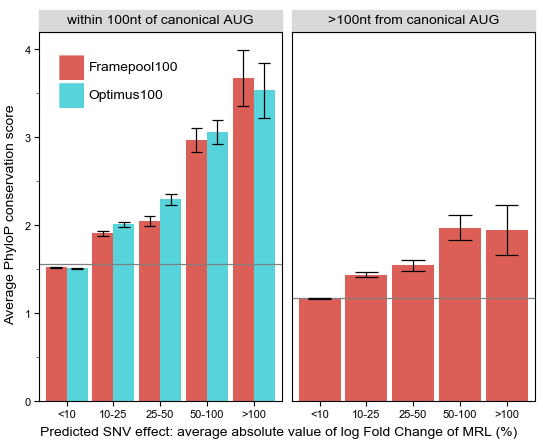

<ggplot: (8752667128100)>

In [474]:
binned_df['Predicted absolute FC (%)'] = pd.Categorical(binned_df['bin'], categories=bin_labels)
binned_df['data_cat'] = pd.Categorical(binned_df['data'], categories=["within 100nt of canonical AUG", ">100nt from canonical AUG"])
df_avgphylop['data_cat'] = pd.Categorical(df_avgphylop['data'], categories=["within 100nt of canonical AUG", ">100nt from canonical AUG"])

p = (plotnine.ggplot(binned_df, plotnine.aes(fill="model", y="PhyloP", x="Predicted absolute FC (%)")) + 
plotnine.geom_bar(position="dodge", stat="identity") + 
 plotnine.xlab("Predicted SNV effect: average absolute value of log Fold Change of MRL (%)") +
 plotnine.scale_y_continuous(expand = (0,0), limits = (0,4.2)) + 
 plotnine.ylab("Average PhyloP conservation score") +
 plotnine.labs(fill="") +
 plotnine.facet_wrap("data_cat") +
plotnine.geom_hline(data=df_avgphylop, mapping=plotnine.aes(yintercept="average conservation"), color="gray") + 
plotnine.geom_errorbar(plotnine.aes(ymin="PhyloP-CI", ymax="PhyloP+CI"), position=plotnine.positions.position_dodge(width=0.9), 
                       colour="black") + 
plotnine.theme_matplotlib() +
plotnine.theme(legend_position = (0.25, 0.8)))
p

In [475]:
p.save("../Graphics/" + "Fig4" + ".svg")

/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../Graphics/Fig4.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)
/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.